# Описание задания
- Реализовать пайплайн CV классификации изображений с помощью Pytorch
-  Создать сервис на Flask, который может классифицировать картинки собак
- Обернуть его в Docker *
- Создать телеграм бота для классификации собак *
Задания со звездочкой не являются обязательными, но будут их выполнение будет являться конкурентным преимуществом при выборе кандидата.

## Данные
Датасет можно взять отсюда https://github.com/fastai/imagenette, подраздел Imagewoof

## Ограничения 
Необходимо использовать Pytorch как базовый фреимворк

## Оценка результатов
- Выбранная архитектура для решения задачи
- Полученные метрики
- Глубина разведочного анализа
- Анализ ошибок



# План работ
- Работа с данными
    - Загрузка необходимых библиотек и данных
    - Подготовка тренировочного и валидационного датасетов
    - Просмотр баланса для классов в данных
- Обучение модели
- Написание простого сервиса, использующего обученную модель
- Оборачивание все в докер 

# Загрузка библиотек и объявление глобальных переменных

## Загрузка библиотек

In [1]:
import os
import time
import torch
import pickle
import tarfile
import torchvision

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm, trange
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from torchvision.datasets.utils import download_url
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.4)

## Загрузка данных

In [2]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
# куда сохранить веса моделек
MAIN_DIR = "/content/drive/MyDrive/"

LABEL_DICT = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./imagewoof2-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/imagewoof2-160'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

  0%|          | 0/92612825 [00:00<?, ?it/s]

['train', 'noisy_imagewoof.csv', 'val']
['n02089973', 'n02105641', 'n02086240', 'n02096294', 'n02115641', 'n02088364', 'n02093754', 'n02099601', 'n02111889', 'n02087394']


In [3]:
# Настройка случайных чисел
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Может уменьшить время выполнения программы
torch.backends.cudnn.deterministic = True

In [18]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Подготовка данных

### Обработка изображений

In [4]:
# Создание двух выборок
TRAIN_DIR = Path('./data/imagewoof2-160/train')
VAL_DIR = Path('./data/imagewoof2-160/val')

# Добавляет в переменную файлы из директории
train_test_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
val_files = sorted(list(VAL_DIR.rglob('*.JPEG')))

print(len(train_test_files))
print(len(val_files))

9025
3929


In [5]:
class ImageWoof:
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'val':
            self.labels = [LABEL_DICT[path.parent.name] for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([     
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'val':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

### Создание даталоадеров

In [6]:
# Поиск лучшего размера батча для обучения с фиксированными параметрами
# batch_size=8       alex_val=           , resnet_val=0.671163
# batch_size=16      alex_val=0.155001   , resnet_val=0.694324 - 
# график валидационной выборки идет выше тренировочного => вариант увеличения количества эпох
# batch_size=32      alex_val=0.152202   , resnet_val=0.629677
# batch_size=64      alex_val=0.150165   , resnet_val=0.590990
# batch_size=128     alex_val=0.137440   , resnet_val=
# batch_size=256     alex_val=   , resnet_val=

# Создание тренировочной и тестовой выборок
train_test_labels = [path.parent.name for path in train_test_files]
val_labels = [path.parent.name for path in val_files]

train_test_dataset = ImageWoof(train_test_files, mode='train')
val_dataset = ImageWoof(val_files, mode='test')

dataloaders = {
    'train_test': torch.utils.data.DataLoader(train_test_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=True)       
}

dataset_sizes = {
    'train_test': len(train_test_dataset),
    'val': len(val_dataset)
}

print(dataset_sizes)

{'train_test': 9025, 'val': 3929}


### Просмотр изображений из тренировочной выборки

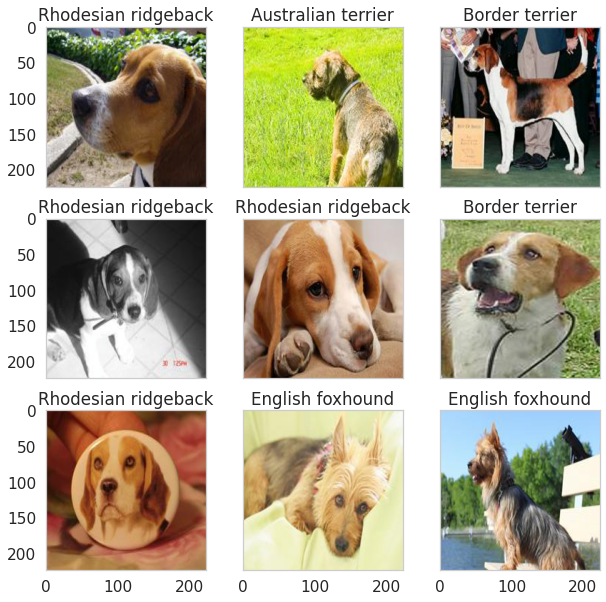

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5000))
    im_val, label = train_test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_test_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение гистограммы по классам

<BarContainer object of 10 artists>

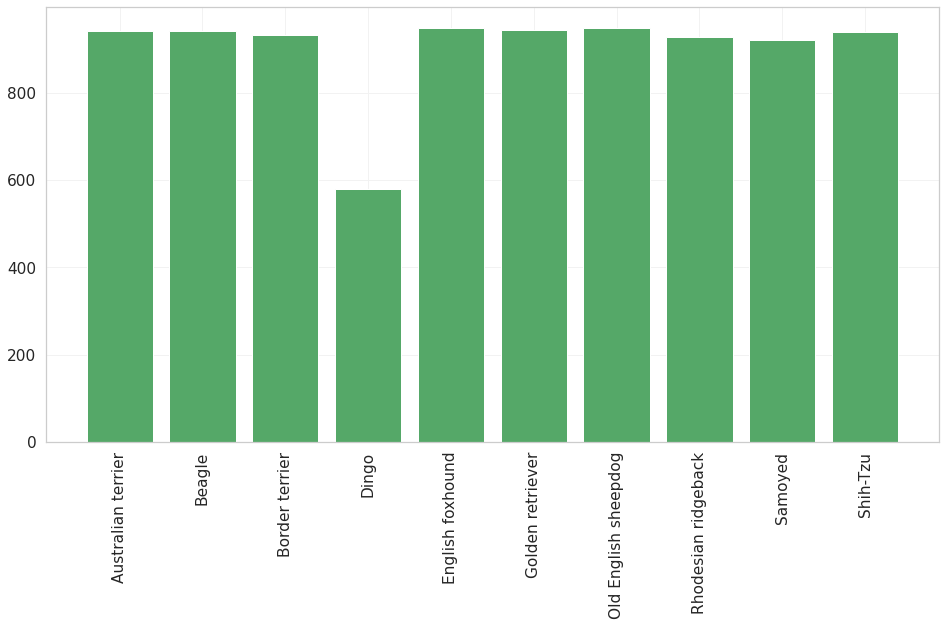

In [8]:
# Словарь с уникальными ключами по именам персонажей
d_index = {}
d_names = {train_test_dataset.label_encoder.inverse_transform([i])[0]:i for i in range(10)}
max_elem_name = ''
max_elem_num = 0
for i in train_test_dataset:
    if i[1] in d_index:
        d_index[i[1]] += 1
    else:
        d_index[i[1]] = 1
    if d_index[i[1]]>max_elem_num:
        max_elem_name = i[1]
        max_elem_num = d_index[i[1]]

plt.figure(figsize=(16, 8))
plt.xticks(rotation=90)
plt.grid(color='0.95')
plt.bar(d_names.keys(), d_index.values(), color='g')

# Выбор модели с лучшими параметрами

## Функция для тренировки модели и расчета метрик

In [16]:
def save_model(model, model_name='model_fasterrcnn_resnet50_5ep.pt'):
    if not os.path.exists(MAIN_DIR+"test_cve/"+ model_name):
        torch.save(model.state_dict(), MAIN_DIR+"test_cve/" + model_name)
        print('Модель сохранена')
    else:
        raise FileExistsError(f'Модель {model_name} уже существует в директории!')

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train_test': [], "val": []}
    f1_metric = {'train_test': [], "val": []}
    accuracy_metric = {'train_test': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train_test', 'val']:
            if phase == 'train_test':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_f1_pred = []
            running_f1_true = []
            running_f1 = {}

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                
                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train_test':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
                running_f1_pred += preds
                running_f1_true += labels.data

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # F1_data
            ## Словари с предсказаниями для каждого класса
            d_pred = {i: [] for i in set(running_f1_true)}
            d_true = {i: [] for i in set(running_f1_true)}

            ## Добавление в словарь предсказанных значений
            for i, j in zip(running_f1_true, running_f1_pred):
                d_pred[i].append(i)
                d_true[i].append(j)

            answer = []

            ## Расчет среднего f1_score по всем значениям
            for key in d_true.keys():
                hist_true = []
                hist_pred = []
                for i in range(len(d_true[key])):
                    hist_true.append(1)
                    hist_pred.append(int(d_true[key][i]==d_pred[key][i]))
                answer.append(f1_score(hist_true, hist_pred))
            epoch_f1 = sum(answer)/len(answer)

            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            f1_metric[phase].append(epoch_f1)
            accuracy_metric[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc, epoch_f1))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, f1_metric, accuracy_metric

## Модель ResNet34

### Настройка параметров

In [74]:
model_resnet34 = models.resnet34(pretrained=True)
model_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
# step_shed = 4, drop = 0.5 - score=0.688470
# step_shed = 6, drop = 0.5 - score=0.707559 lr=3e-3 gamma=0.3
# step_shed = 6, drop = 0.5 - score=0.707559 lr=3e-3 gamma=0.3 steps=10
# step_shed = 6, drop = 0.5 - score=0.667600 lr=6e-3 gamma=0.1 steps=10


# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_resnet34.layer1.parameters():
    param.requires_grad = False
for param in model_resnet34.layer2.parameters():
    param.requires_grad = False
for param in model_resnet34.layer3.parameters():
    param.requires_grad = False
for param in model_resnet34.layer4.parameters():
    param.requires_grad = False

# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 512

# Заменяем Fully-Connected слой на наш линейный классификатор
model_resnet34.fc = nn.Sequential(OrderedDict([
    ('batch_norm', nn.BatchNorm1d(num_features)),
    ('drop1', nn.Dropout(p=0.5)),
    ('linear1', nn.Linear(num_features, len(np.unique(train_test_labels))))
]))


# Использовать ли GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model_resnet34 = model_resnet34.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.AdamW(model_resnet34.parameters(), lr=3e-3)

# Умножает learning_rate на 0.1 каждые 4 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.3)

In [76]:
model_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [77]:
model_resnet34, losses, f1_metric, accuracy_metric = train_model(model_resnet34, loss_fn, optimizer_ft, 
                                                             exp_lr_scheduler, num_epochs=7)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

Training complete in 27m 7s
Best val Acc: 0.730211


In [78]:
# При необходимости есть возможность использовать фукнкции для работы с моделью
model_name='model_resnet34_7ep.pt'
save_model(model_name=model_name, model=model_resnet34)

Модель сохранена


### Смотрим на графики для модели

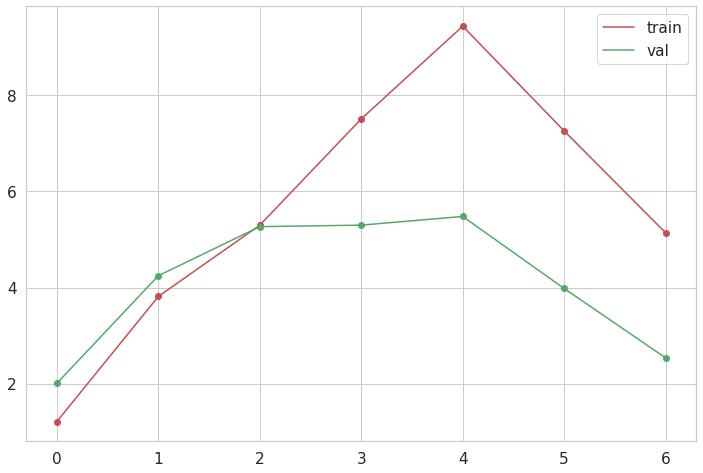

In [79]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train_test'], 'r-', label="train")
plt.plot(losses['val'], 'g-', label="val")
plt.plot(losses['train_test'], 'ro')
plt.plot(losses['val'], 'go')
plt.legend()
plt.show()

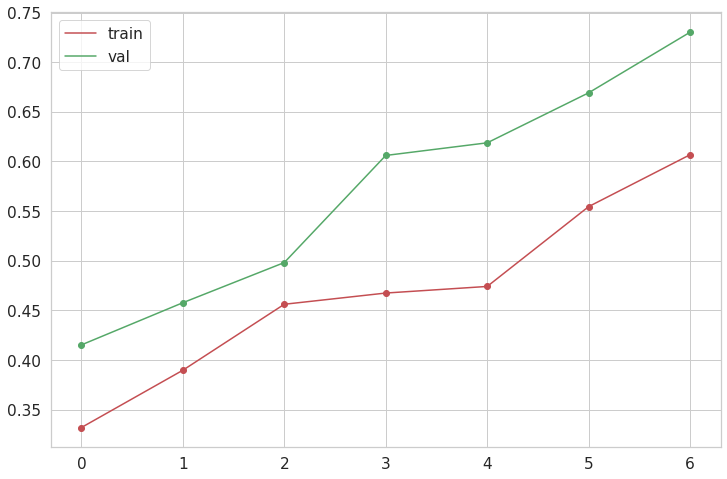

In [80]:
# Построим график метрик качества при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(accuracy_metric['train_test'], 'r-', label="train")
plt.plot(accuracy_metric['val'], 'g-', label="val")
plt.plot(accuracy_metric['train_test'], 'ro')
plt.plot(accuracy_metric['val'], 'go')
plt.legend()
plt.show()

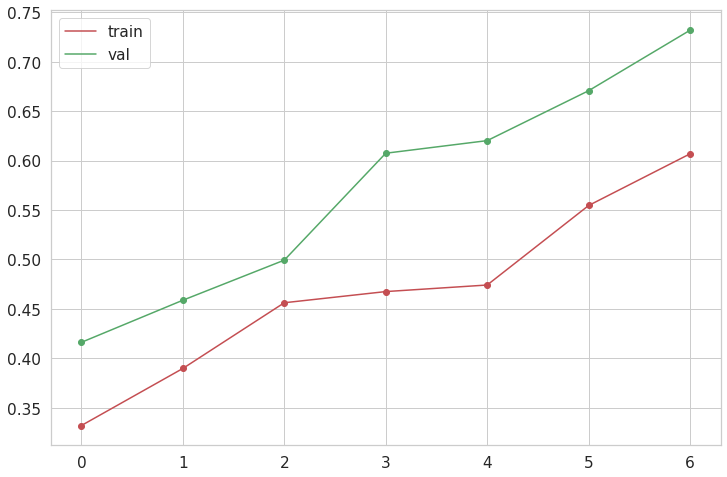

In [81]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(f1_metric['train_test'], 'r-', label="train")
plt.plot(f1_metric['val'], 'g-', label="val")
plt.plot(f1_metric['train_test'], 'ro')
plt.plot(f1_metric['val'], 'go')
plt.legend()
plt.show()

## Модель ResNet18

### Настройка параметров

In [23]:
model_resnet18 = models.resnet18(pretrained=True)
model_resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_resnet18.layer1.parameters():
    param.requires_grad = False
for param in model_resnet18.layer2.parameters():
    param.requires_grad = False
for param in model_resnet18.layer3.parameters():
    param.requires_grad = False
for param in model_resnet18.layer4.parameters():
    param.requires_grad = False

# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 512

# Заменяем Fully-Connected слой на наш линейный классификатор
model_resnet18.fc = nn.Sequential(OrderedDict([
    ('batch_norm', nn.BatchNorm1d(num_features)),
    ('drop', nn.Dropout(p=0.5)),
    ('linerar1', nn.Linear(num_features, len(np.unique(train_test_labels))))
]))


# Использовать ли GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model_resnet18 = model_resnet18.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.AdamW(model_resnet18.parameters(), lr=3e-3)

# Умножает learning_rate на 0.1 каждые 4 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.3)

In [25]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
model_resnet18, losses, f1_metric, accuracy_metric = train_model(model_resnet18, loss_fn, optimizer_ft, 
                                                             exp_lr_scheduler, num_epochs=7)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

Training complete in 18m 21s
Best val Acc: 0.518198


In [27]:
# При необходимости есть возможность использовать фукнкции для работы с моделью
model_name='model_resnet18_7ep.pt'

save_model(model_name=model_name, model=model_resnet34)

Модель сохранена


### Смотрим на графики для модели

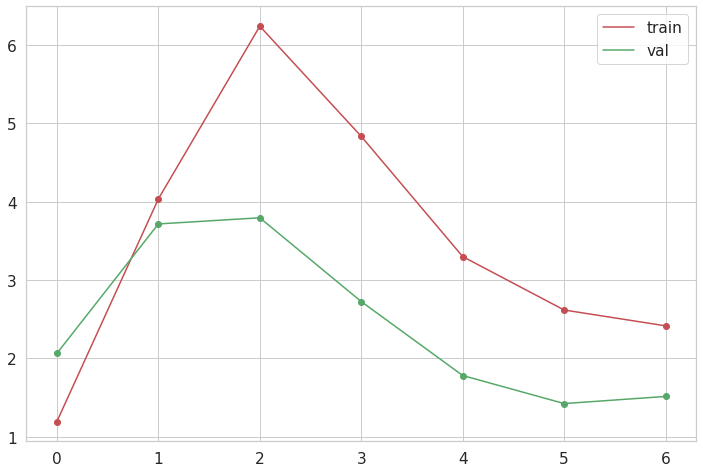

In [28]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train_test'], 'r-', label="train")
plt.plot(losses['val'], 'g-', label="val")
plt.plot(losses['train_test'], 'ro')
plt.plot(losses['val'], 'go')
plt.legend()
plt.show()

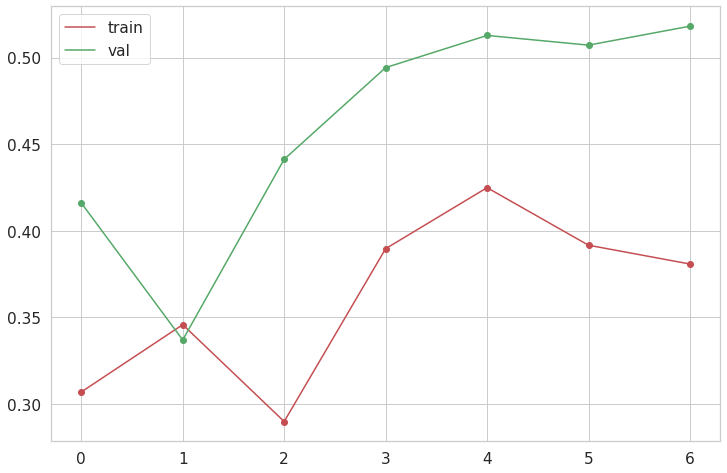

In [29]:
# Построим график метрик качества при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(accuracy_metric['train_test'], 'r-', label="train")
plt.plot(accuracy_metric['val'], 'g-', label="val")
plt.plot(accuracy_metric['train_test'], 'ro')
plt.plot(accuracy_metric['val'], 'go')
plt.legend()
plt.show()

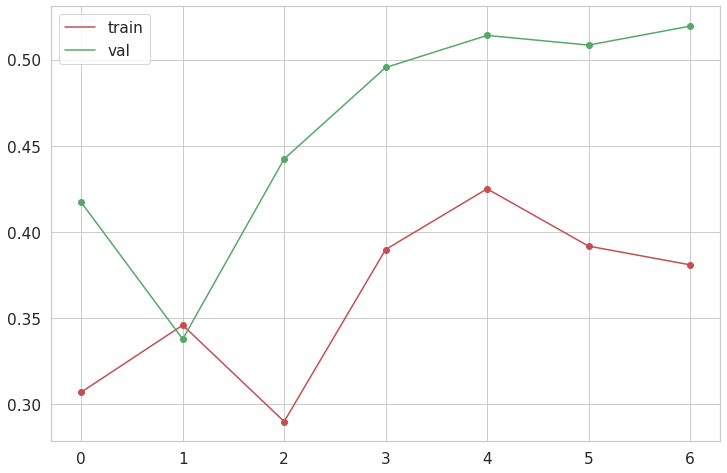

In [30]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(f1_metric['train_test'], 'r-', label="train")
plt.plot(f1_metric['val'], 'g-', label="val")
plt.plot(f1_metric['train_test'], 'ro')
plt.plot(f1_metric['val'], 'go')
plt.legend()
plt.show()

## Модель AlexNet с одним полносвязным слоем
Качество модели значительно уступает модели ResNet18    
Не имеет смысла пытаться улучшать данную модель  
Видимо residual blocks вносит веесомый вклад       
    

### Настройка параметров

In [ ]:
model_alex = models.alexnet(pretrained=True)
model_alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#  - on validation data - best - layers=10 - p=0.5 - lr=3e-3


layers_to_unfreeze = 10

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_alex.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features - это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216

# Заменяем Fully-Connected слой на наш линейный классификатор
model_alex.classifier = nn.Sequential(OrderedDict([
    ('batch_norm', nn.BatchNorm1d(num_features)),
    ('drop', nn.Dropout(p=0.5)),
    ('linerar1', nn.Linear(num_features, len(np.unique(train_test_labels))))
]))


# Использовать ли GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model_alex = model_alex.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.AdamW(model_alex.parameters(), lr=3e-3)

# Умножает learning_rate на 0.1 каждые 4 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.3)

In [ ]:
model_alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (batch_norm): BatchNorm1d(9216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
model_alex, losses, f1_metric, accuracy_metric = train_model(model_alex, loss_fn, optimizer_ft, 
                                                             exp_lr_scheduler, num_epochs=7)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

train_test iter::   0%|          | 0/564 [00:00<?, ?it/s]

val iter::   0%|          | 0/245 [00:00<?, ?it/s]

Training complete in 11m 34s
Best val Acc: 0.155001


### Смотрим на графики для модели

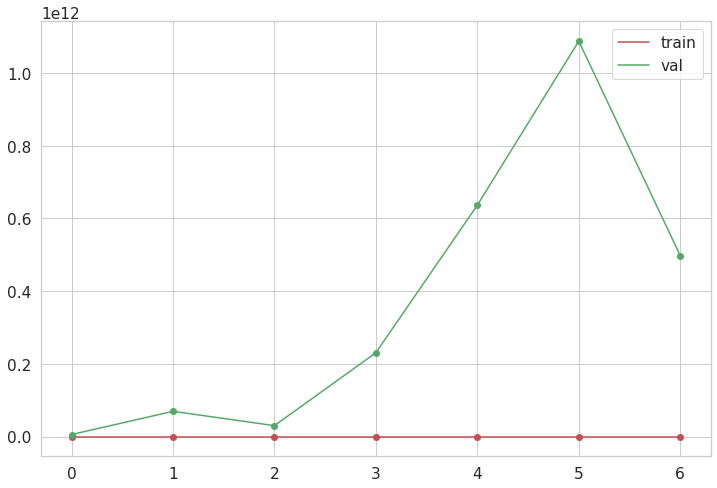

In [ ]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train_test'], 'r-', label="train")
plt.plot(losses['val'], 'g-', label="val")
plt.plot(losses['train_test'], 'ro')
plt.plot(losses['val'], 'go')
plt.legend()
plt.show()

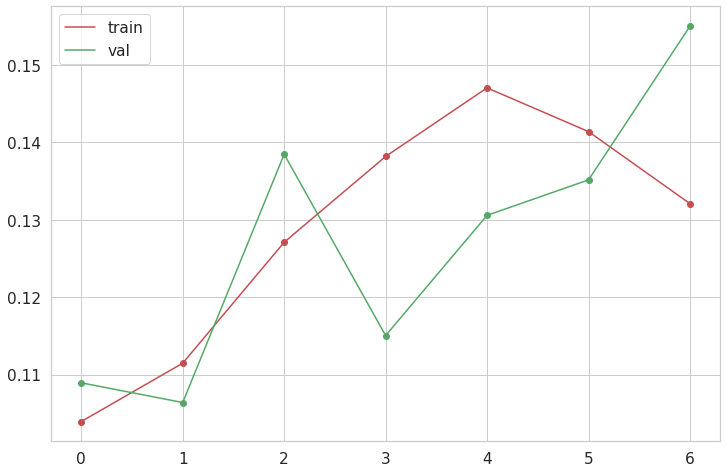

In [ ]:
# Построим график метрик качества при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(accuracy_metric['train_test'], 'r-', label="train")
plt.plot(accuracy_metric['val'], 'g-', label="val")
plt.plot(accuracy_metric['train_test'], 'ro')
plt.plot(accuracy_metric['val'], 'go')
plt.legend()
plt.show()

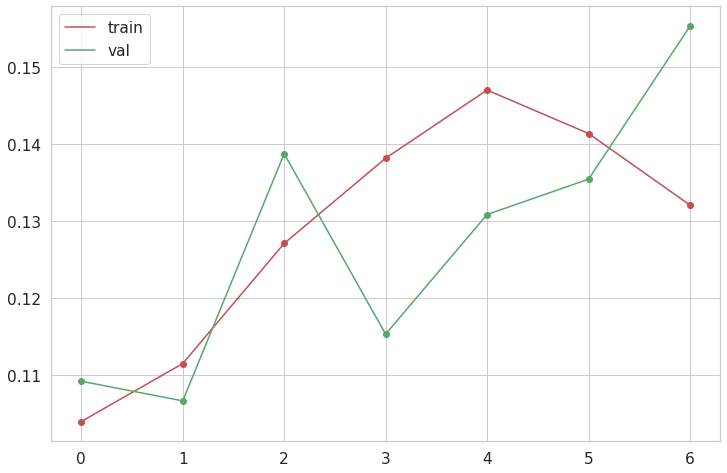

In [ ]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(f1_metric['train_test'], 'r-', label="train")
plt.plot(f1_metric['val'], 'g-', label="val")
plt.plot(f1_metric['train_test'], 'ro')
plt.plot(f1_metric['val'], 'go')
plt.legend()
plt.show()

## Модель VGG-11 с batch normalization
Не обучалась, тк ResNet победил

### Настройка параметров

In [ ]:
model = models.vgg11_bn(pretrained=True)
model

### Смотрим на графики для модели

In [ ]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train_test'], 'r-', label="train")
plt.plot(losses['val'], 'g-', label="val")
plt.plot(losses['train_test'], 'ro')
plt.plot(losses['val'], 'go')
plt.legend()
plt.show()

In [ ]:
# Построим график метрик качества при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(accuracy_metric['train_test'], 'r-', label="train")
plt.plot(accuracy_metric['val'], 'g-', label="val")
plt.plot(accuracy_metric['train_test'], 'ro')
plt.plot(accuracy_metric['val'], 'go')
plt.legend()
plt.show()

In [ ]:
# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(f1_metric['train_test'], 'r-', label="train")
plt.plot(f1_metric['val'], 'g-', label="val")
plt.plot(f1_metric['train_test'], 'ro')
plt.plot(f1_metric['val'], 'go')
plt.legend()
plt.show()

# Аугментация изображений
Получается много изображений, которые дорого обучать по времени

In [ ]:
def save_hflipper(path_in, image):
    """
    Добавление нового изображения с преобразованием RandomHorizontalFlip
    """
    transformed_imgs = T.RandomHorizontalFlip(p=1)(image)
    s = str(path_in).split('/')
    s[-1] = s[-1].replace('.', '_rhf.')
    new_path = '/'.join(s)
    transformed_imgs.save(new_path)


def save_vflipper(path_in, image):
    """
    Добавление нового изображения с преобразованием RandomVerticalFlip
    """
    transformed_imgs = T.RandomVerticalFlip(p=1)(image)
    s = str(path_in).split('/')
    s[-1] = s[-1].replace('.', '_rvf.')
    new_path = '/'.join(s)
    transformed_imgs.save(new_path)


def save_jitter(path_in, image):
    """
    Добавление нового изображения с преобразованием ColorJitter
    """
    transformed_imgs = T.ColorJitter(brightness=.5, hue=.3)(image)
    s = str(path_in).split('/')
    s[-1] = s[-1].replace('.', '_cj.')
    new_path = '/'.join(s)
    transformed_imgs.save(new_path)


print("Добавление в выборку обновленных фото")
# for i in tqdm(train_test_files):
#     orig_img = Image.open(i)

#     if 800 <= d_index[d_names[LABEL_DICT[i.parent.name]]]:
#         save_hflipper(path_in=i, image=orig_img)
#         save_vflipper(path_in=i, image=orig_img)

#     elif d_index[d_names[LABEL_DICT[i.parent.name]]] < 800:
#         save_hflipper(path_in=i, image=orig_img)
#         save_vflipper(path_in=i, image=orig_img)
#         save_jitter(path_in=i, image=orig_img)

print("Окончание добавление в выборку обновленных фото")

Добавление в выборку обновленных фото


  0%|          | 0/9025 [00:00<?, ?it/s]

Окончание добавление в выборку обновленных фото


### Обновление переменных

In [ ]:
# Создание двух выборок
TRAIN_DIR = Path('./data/imagewoof2-160/train')
VAL_DIR = Path('./data/imagewoof2-160/val')

# Добавляет в переменную файлы из директории
train_test_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
val_files = sorted(list(VAL_DIR.rglob('*.JPEG')))

print(len(train_test_files))
print(len(val_files))

27655
3929


### Обновление даталоадеров

In [ ]:
# Поиск лучшего размера батча для обучения с фиксированными параметрами
# batch_size=8       alex_val=   , resnet_val=
# batch_size=16      alex_val=   , resnet_val=
# batch_size=32      alex_val=   , resnet_val=
# batch_size=64      alex_val=   , resnet_val=
# batch_size=128     alex_val=   , resnet_val=
# batch_size=256     alex_val=   , resnet_val=

# Создание тренировочной и тестовой выборок
train_test_labels = [path.parent.name for path in train_test_files]
val_labels = [path.parent.name for path in val_files]

train_test_dataset = ImageWoof(train_test_files, mode='train')
val_dataset = ImageWoof(val_files, mode='test')

dataloaders = {
    'train_test': torch.utils.data.DataLoader(train_test_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)       
}

dataset_sizes = {
    'train_test': len(train_test_dataset),
    'val': len(val_dataset)
}

print(dataset_sizes)

{'train_test': 27655, 'val': 3929}


### Просмотр изображений из тренировочной выборки

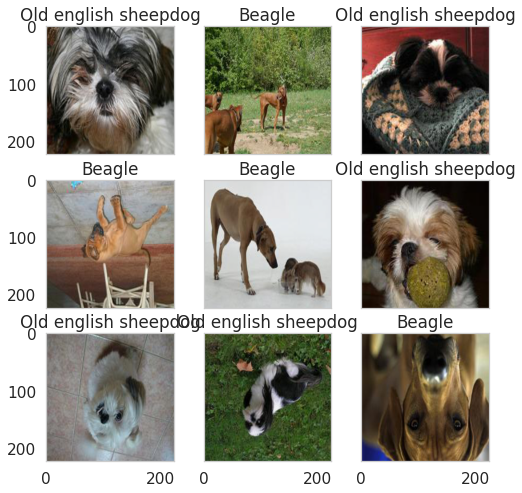

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5000))
    im_val, label = train_test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_test_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)